In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
from datetime import datetime

# XML dosyasını okuma
def read_xml_data(file_path):
    # XML dosyasını yükle
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Verileri saklamak için liste
    step_records = []

    # Adım kayıtlarını XML'den çıkarma
    for record in root.findall(".//Record[@type='HKQuantityTypeIdentifierStepCount']"):
        start_date = datetime.strptime(record.get('startDate'), '%Y-%m-%d %H:%M:%S %z')
        steps = int(record.get('value', 0))

        # Her kaydı listeye ekle
        step_records.append({
            'date': start_date.date(),
            'steps': steps
        })

    # DataFrame oluşturma
    df = pd.DataFrame(step_records)
    return df

# Günlük toplam adım sayısını hesaplama
def calculate_daily_steps(df):
    daily_steps = df.groupby('date')['steps'].sum().reset_index()
    return daily_steps

# Veriyi okuma ve işleme
file_path = 'export.xml'  # XML dosya yolunu buraya yazın
df = read_xml_data(file_path)
daily_steps = calculate_daily_steps(df)

# İlk birkaç satırı görüntüleme
print(daily_steps.head())


         date  steps
0  2017-07-16   2532
1  2017-07-17   1858
2  2017-07-18   1000
3  2017-07-19   1353
4  2017-07-20    467


C:\Users\asus\AppData\Local\Temp\ipykernel_26884\1124311886.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])


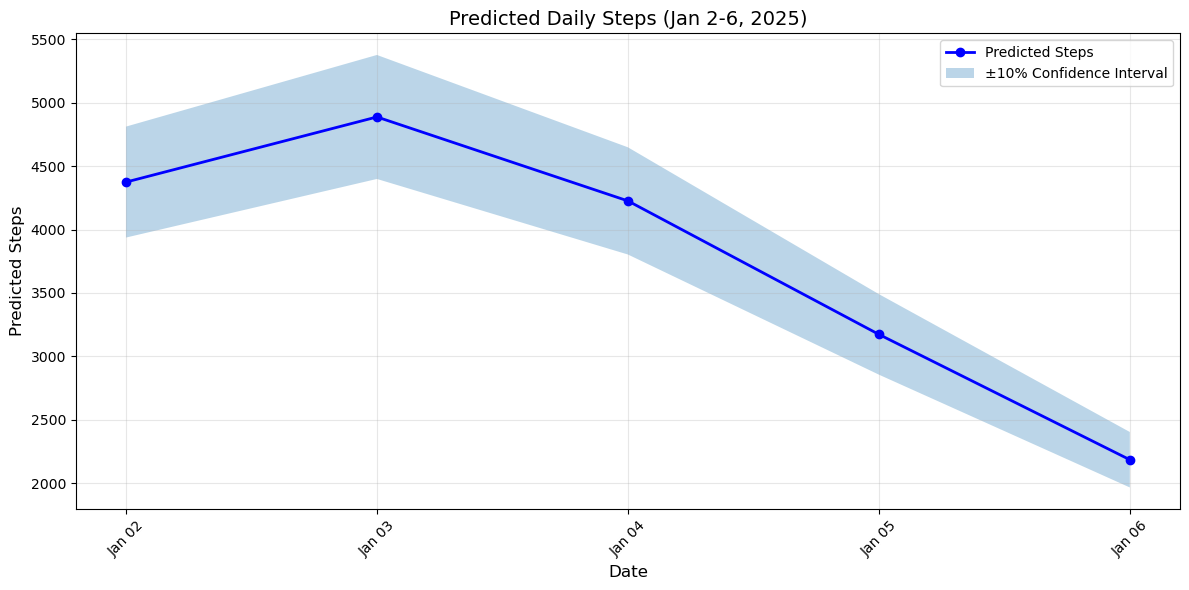


Predicted Daily Steps:
Date: January 02, 2025, Predicted Steps: 4374
Date: January 03, 2025, Predicted Steps: 4887
Date: January 04, 2025, Predicted Steps: 4226
Date: January 05, 2025, Predicted Steps: 3173
Date: January 06, 2025, Predicted Steps: 2185

Model Performance Metrics:
Mean Squared Error: 510935.16
R² Score: 0.91


In [24]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def remove_outliers(df, column, threshold=3):
    z_scores = zscore(df[column])
    abs_z_scores = np.abs(z_scores)
    return df[abs_z_scores < threshold]

# Prepare daily features
daily_steps['year'] = daily_steps['date'].apply(lambda x: x.year)
daily_steps['month'] = daily_steps['date'].apply(lambda x: x.month)
daily_steps['day'] = daily_steps['date'].apply(lambda x: x.day)
daily_steps['day_of_year'] = daily_steps['date'].apply(lambda x: x.timetuple().tm_yday)
daily_steps['day_of_week'] = pd.to_datetime(daily_steps['date']).dt.dayofweek

# Remove COVID period data
covid_start = pd.to_datetime('2020-03-13')
covid_end = pd.to_datetime('2021-03-01')
cleaned_data = daily_steps[~((pd.to_datetime(daily_steps['date']) >= covid_start) & 
                            (pd.to_datetime(daily_steps['date']) <= covid_end))]

# Clean and prepare data
cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])
cleaned_data = cleaned_data[cleaned_data['date'] <= pd.to_datetime('2024-09-30')]
cleaned_data = remove_outliers(cleaned_data, 'steps', threshold=3)

# Prepare training data
X_train = cleaned_data[['year', 'month', 'day', 'day_of_year', 'day_of_week']]
y_train = cleaned_data['steps']

# Create test data for Jan 2-6, 2025
test_dates = pd.date_range(start='2025-01-02', end='2025-01-06')
test_data = pd.DataFrame({'date': test_dates})
test_data['year'] = test_data['date'].dt.year
test_data['month'] = test_data['date'].dt.month
test_data['day'] = test_data['date'].dt.day
test_data['day_of_year'] = test_data['date'].dt.dayofyear
test_data['day_of_week'] = test_data['date'].dt.dayofweek

# Train model and make predictions
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
X_test = test_data[['year', 'month', 'day', 'day_of_year', 'day_of_week']]
test_data['predicted_steps'] = model.predict(X_test)

# Ensure predictions are positive
test_data['predicted_steps'] = test_data['predicted_steps'].apply(lambda x: max(x, 100))

# Calculate model performance
y_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

# Plotting
plt.figure(figsize=(12, 6))

# Plot predictions
plt.plot(test_data['date'], test_data['predicted_steps'], marker='o', linewidth=2, 
         label='Predicted Steps', color='blue')

# Add confidence interval
plt.fill_between(test_data['date'], 
                 test_data['predicted_steps'] * 0.9,
                 test_data['predicted_steps'] * 1.1,
                 alpha=0.3, label='±10% Confidence Interval')

# Customize plot
plt.title('Predicted Daily Steps (Jan 2-6, 2025)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Predicted Steps', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Format x-axis dates
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %d'))
plt.xticks(test_data['date'], rotation=45)

plt.tight_layout()
plt.show()

# Print predictions and model performance
print("\nPredicted Daily Steps:")
for _, row in test_data.iterrows():
    print(f"Date: {row['date'].strftime('%B %d, %Y')}, Predicted Steps: {int(row['predicted_steps'])}")

print(f"\nModel Performance Metrics:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Real Daily Steps in Between 02-09

Step Counts (January 2, 2025 - January 9, 2025):
Date: January 02, 2025, Steps: 8092
Date: January 03, 2025, Steps: 5471
Date: January 04, 2025, Steps: 4728
Date: January 05, 2025, Steps: 5640
Date: January 06, 2025, Steps: 1765


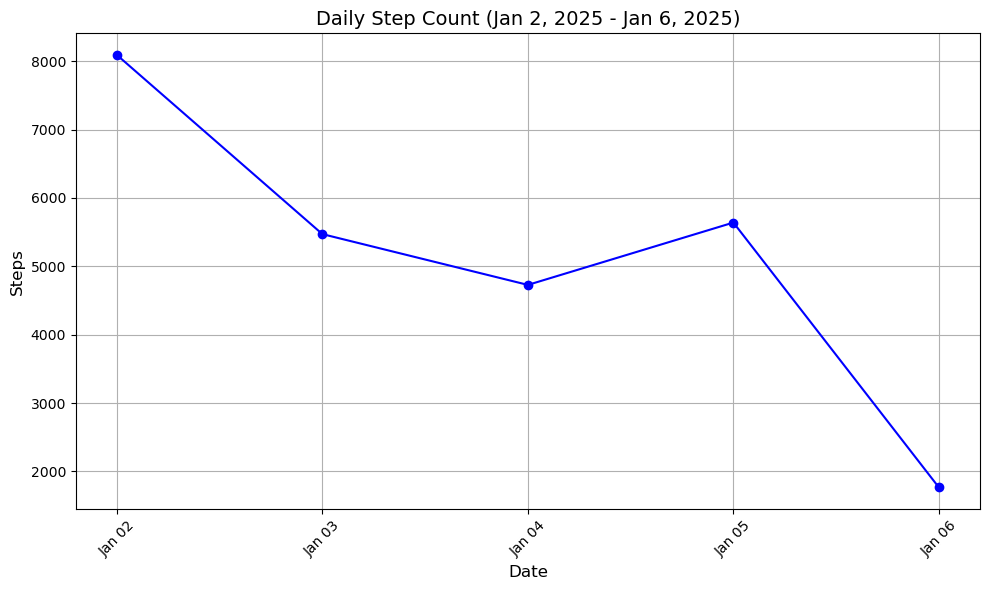

In [20]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Read XML file
def read_xml_data(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    step_records = []
    
    for record in root.findall(".//Record[@type='HKQuantityTypeIdentifierStepCount']"):
        start_date = datetime.strptime(record.get('startDate'), '%Y-%m-%d %H:%M:%S %z')
        steps = float(record.get('value', 0))
        
        step_records.append({
            'date': start_date.date(),
            'steps': steps
        })
    
    df = pd.DataFrame(step_records)
    return df

# Calculate daily total steps
def calculate_daily_steps(df):
    daily_steps = df.groupby('date')['steps'].sum().reset_index()
    return daily_steps

# Read and process data
file_path = 'export2.xml'
df = read_xml_data(file_path)
daily_steps = calculate_daily_steps(df)

# Filter data between January 2, 2025 - January 9, 2025
start_date = pd.to_datetime('2025-01-02')
end_date = pd.to_datetime('2025-01-09')

filtered_data = daily_steps[(daily_steps['date'] >= start_date.date()) & (daily_steps['date'] <= end_date.date())]

# Print step counts
print("Step Counts (January 2, 2025 - January 9, 2025):")
for index, row in filtered_data.iterrows():
    print(f"Date: {row['date'].strftime('%B %d, %Y')}, Steps: {int(row['steps'])}")

# Create visualization
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['date'], filtered_data['steps'], marker='o', linestyle='-', color='b')
plt.title('Daily Step Count (Jan 2, 2025 - Jan 6, 2025)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Steps', fontsize=12)

# Format x-axis dates
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %d'))
plt.xticks(filtered_data['date'], rotation=45)

plt.grid(True)
plt.tight_layout()

# Show graph
plt.show()